22BAI1173\
11/03/2025\
Lab 9\
L39+L40\
chatgpt: https://chatgpt.com/share/67d02329-5fac-8004-a02a-75c91c8f6f88

In [47]:
import warnings
warnings.filterwarnings('ignore')

# Question 1 - Develop an algorithm to detect multiple objects in a satellite image and approximate their shapes using Convex Hull.
  • Preprocess the image to enhance object edges.\
  • Use a clustering algorithm (K-Means/DBSCAN) to segment different land areas.\
  • Compute the Convex Hull for each segmented object.\
  • Evaluate how well the convex approximation fits real-world object shapes.

In [187]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial import ConvexHull
from sklearn.metrics import silhouette_score, davies_bouldin_score
from shapely.geometry import Polygon

In [188]:
image_path = 'satellite_img.jpg'

In [189]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return img, edges

In [190]:
img, edges = preprocess_image(image_path)

In [191]:
def segment_image(edges, n_clusters=3, use_dbscan=False):
    # Reshape the edge image for clustering
    points = np.column_stack(np.where(edges > 0))

    if use_dbscan:
        clustering = DBSCAN(eps=5, min_samples=5).fit(points)
    else:
        clustering = KMeans(n_clusters=n_clusters, random_state=42).fit(points)

    labels = clustering.labels_
    return points, labels

In [214]:
n_clusters=30
use_dbscan=False

In [215]:
points, labels = segment_image(edges, n_clusters, use_dbscan)

In [211]:
def compute_convex_hulls(points, labels):
    hulls = []
    unique_labels = set(labels)
    for label in unique_labels:
        if label == -1:
            continue
        cluster_points = points[labels == label]
        if len(cluster_points) >= 3:
            hull = ConvexHull(cluster_points)
            hulls.append((cluster_points, hull))
    return hulls

In [216]:
hulls = compute_convex_hulls(points, labels)

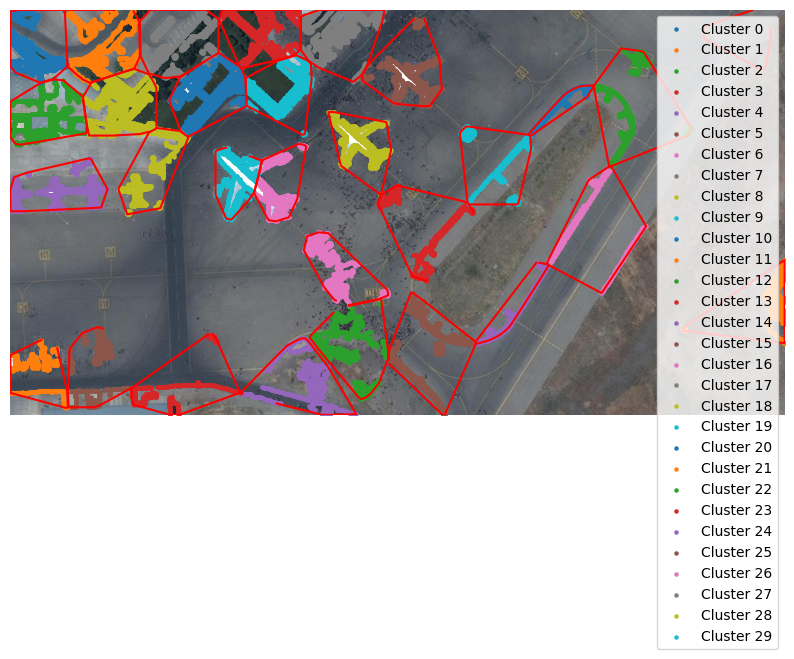

In [217]:
plt.figure(figsize=(10, 10))
plt.imshow(img)

# Plot clustered points
for label in set(labels):
    if label == -1:
        continue
    cluster_points = points[labels == label]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=5, label=f'Cluster {label}')

# Plot convex hulls
for cluster_points, hull in hulls:
    hull_points = cluster_points[hull.vertices]
    plt.plot(hull_points[:, 1], hull_points[:, 0], 'r-', linewidth=1.5)

plt.legend()
plt.axis('off')
plt.show()

In [ ]:
def evaluate_clustering(points, labels):
    if len(set(labels)) > 1:
        silhouette = silhouette_score(points, labels)
        db_index = davies_bouldin_score(points, labels)
    else:
        silhouette = None
        db_index = None
    return silhouette, db_index

In [ ]:
def evaluate_convex_hull(hulls):
    compactness_scores = []
    perimeter_area_ratios = []

    for cluster_points, hull in hulls:
        hull_points = cluster_points[hull.vertices]
        polygon = Polygon(hull_points)

        minx, miny, maxx, maxy = polygon.bounds
        bbox_area = (maxx - minx) * (maxy - miny)
        compactness = polygon.area / bbox_area if bbox_area > 0 else 0

        perimeter_area_ratio = polygon.length / polygon.area if polygon.area > 0 else 0

        compactness_scores.append(compactness)
        perimeter_area_ratios.append(perimeter_area_ratio)

    avg_compactness = np.mean(compactness_scores) if compactness_scores else None
    avg_perimeter_area_ratio = np.mean(perimeter_area_ratios) if perimeter_area_ratios else None

    return avg_compactness, avg_perimeter_area_ratio

In [ ]:
silhouette, db_index = evaluate_clustering(points, labels)
compactness, perimeter_area_ratio = evaluate_convex_hull(hulls)

In [ ]:
print(f"Silhouette Score: {silhouette:.4f}" if silhouette is not None else "Silhouette Score: N/A")
print(f"Davies-Bouldin Index: {db_index:.4f}" if db_index is not None else "Davies-Bouldin Index: N/A")
print(f"Convex Hull Compactness: {compactness:.4f}" if compactness is not None else "Compactness: N/A")
print(f"Perimeter-to-Area Ratio: {perimeter_area_ratio:.4f}" if perimeter_area_ratio is not None else "Perimeter-to-Area Ratio: N/A")

Silhouette Score: 0.3954
Davies-Bouldin Index: 0.9633
Convex Hull Compactness: 0.7216
Perimeter-to-Area Ratio: 0.0105


# Question 2 - A medical image processing system is being developed to detect brain tumors in MRI scans using GLCM texture features.
  • Extract regions of interest (ROI) from MRI images.\
  • Compute GLCM matrices at multiple angles and distances.\
  • Extract texture features (contrast, energy, correlation, homogeneity).\
  • Train an ML classifier to differentiate between tumor and non-tumor regions.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [110]:
image_paths = ['mri_1.jpg', 'mri_2.jpg', 'mri_3.jpg']

In [111]:
labels = [0, 1, 1]

In [112]:
def load_and_preprocess(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

    img = cv2.equalizeHist(img)
    return img

In [115]:
def extract_rois(img, min_area=1000, max_area=3000, block_size=11, C=2):
    # Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, block_size, C)

    # Morphological operations to refine the mask
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find contours on the refined mask
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rois = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            x, y, w, h = cv2.boundingRect(contour)
            rois.append((x, y, w, h))

    return rois

In [116]:
def extract_glcm_features(roi, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    glcm = graycomatrix(roi, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    features = {
        'contrast': np.mean(graycoprops(glcm, 'contrast')),
        'energy': np.mean(graycoprops(glcm, 'energy')),
        'correlation': np.mean(graycoprops(glcm, 'correlation')),
        'homogeneity': np.mean(graycoprops(glcm, 'homogeneity'))
    }
    return features

In [117]:
def plot_rois(img, rois):
    plt.figure(figsize=(8, 8))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    for (x, y, w, h) in rois:
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(img_rgb)
    plt.title("Extracted ROIs")
    plt.axis('off')
    plt.show()

In [118]:
def prepare_dataset(image_paths, labels):
    data = []
    for img_path, label in zip(image_paths, labels):
        img = load_and_preprocess(img_path)
        rois = extract_rois(img)
        plot_rois(img, rois)

        for (x, y, w, h) in rois:
            roi = img[y:y+h, x:x+w]
            features = extract_glcm_features(roi)
            features['label'] = label
            data.append(features)

    df = pd.DataFrame(data)
    return df

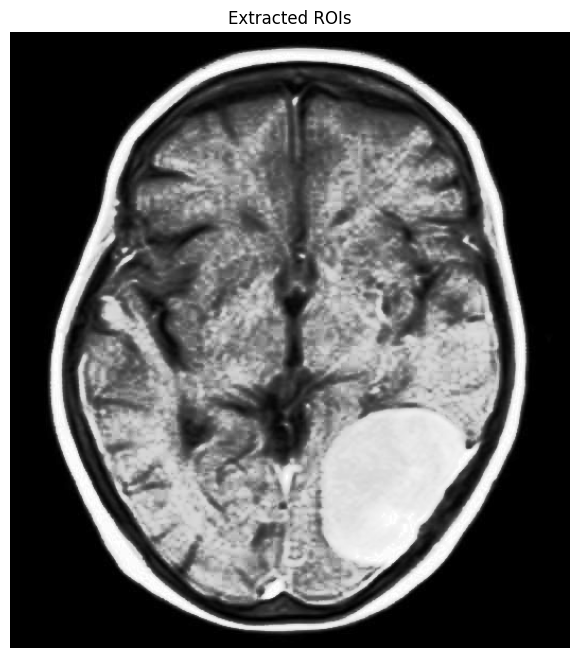

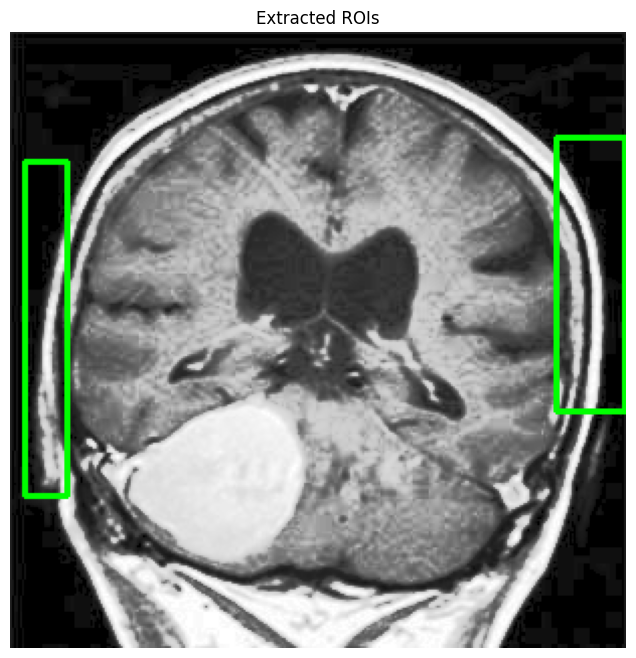

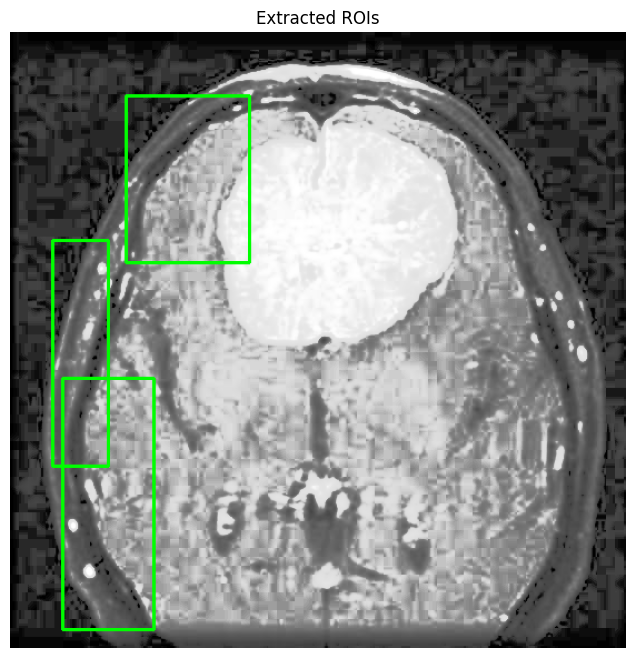

In [119]:
df = prepare_dataset(image_paths, labels)

In [78]:
X = df.drop('label', axis=1)
y = df['label']

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

In [121]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [122]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [123]:
print(f'Accuracy: {acc:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))

Accuracy: 0.0000

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0


Confusion Matrix:
 [[0 0]
 [1 0]]


# Question 3 - A dermatology AI system must analyze microtextures in skin images to classify different skin diseases using Multi-Scale LBP.
  • Extract LBP features at multiple scales (3×3, 5×5, 7×7 neighborhoods).\
  • Train a convolutional neural network (CNN) using extracted features.\
  • Evaluate model performance across various skin disease datasets.\
  • Compare results with GLCM-based classification.

In [182]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow import keras

In [146]:
def load_and_preprocess(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    # img = img.astype('float32') / 255.0  # Remove this line or convert back to uint8
    # Add this line to convert to uint8 if needed:
    img = img.astype('uint8')
    return img

In [137]:
def extract_multiscale_lbp(img, radii=[1, 2, 3], points=[8, 16, 24]):
    lbp_maps = []
    lbp_features = []

    for radius, point in zip(radii, points):
        lbp = local_binary_pattern(img, point, radius, method='uniform')
        lbp_maps.append(lbp)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, point + 3), range=(0, point + 2))
        hist = hist.astype('float') / hist.sum()
        lbp_features.extend(hist)

    # Plot LBP maps
    fig, axes = plt.subplots(1, len(radii), figsize=(12, 4))
    for i, radius in enumerate(radii):
        axes[i].imshow(lbp_maps[i], cmap='gray')
        axes[i].set_title(f'LBP (radius={radius})')
        axes[i].axis('off')
    plt.show()

    return lbp_features

In [138]:
def extract_glcm_features(img):
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    features = {
        'contrast': np.mean(graycoprops(glcm, 'contrast')),
        'energy': np.mean(graycoprops(glcm, 'energy')),
        'correlation': np.mean(graycoprops(glcm, 'correlation')),
        'homogeneity': np.mean(graycoprops(glcm, 'homogeneity'))
    }
    return list(features.values())

In [169]:
def prepare_dataset(image_paths, labels):
    lbp_data = []
    glcm_data = []
    final_labels = []  # Track successful samples

    for img_path, label in zip(image_paths, labels):
        img = load_and_preprocess(img_path)

        try:
            lbp_features = extract_multiscale_lbp(img)
            if len(lbp_features) > 0:  # Ensure LBP extraction succeeded
                lbp_data.append(lbp_features)
                final_labels.append(label)
            else:
                print(f"⚠️ Empty LBP features for {img_path}, skipping...")

            glcm_features = extract_glcm_features(img)
            if len(glcm_features) > 0:
                glcm_data.append(glcm_features)

        except Exception as e:
            print(f"⚠️ Skipping {img_path} due to error: {e}")

    lbp_df = pd.DataFrame(lbp_data)
    lbp_df['label'] = final_labels

    # Sync GLCM labels to avoid misalignment
    glcm_df = pd.DataFrame(glcm_data)
    glcm_df['label'] = final_labels[:len(glcm_data)]

    print(f"✅ Loaded {len(lbp_df)} LBP samples, {len(glcm_df)} GLCM samples")
    return lbp_df, glcm_df

In [178]:
def build_dense_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [184]:
def train_dense(X, y):
    X = np.array(X)
    y = np.array(y)

    assert X.shape[0] == y.shape[0], f"Data size mismatch: {X.shape[0]} vs {y.shape[0]}"

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_dense_model(X_train.shape[1:])

    history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2, verbose=1)

    y_pred = (model.predict(X_test) > 0.5).astype('int32')

    acc = accuracy_score(y_test, y_pred)
    print(f'Dense Network Accuracy: {acc:.4f}')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

In [143]:
def train_glcm_classifier(df):
    X = df.drop('label', axis=1)
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f'GLCM Classifier Accuracy: {acc:.4f}')

    # === Confusion Matrix ===
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix (GLCM Classifier)')
    plt.show()

In [144]:
image_paths = ['skin_1.jpg', 'skin_2.jpg', 'skin_3.jpg']
labels = [1, 0, 1]

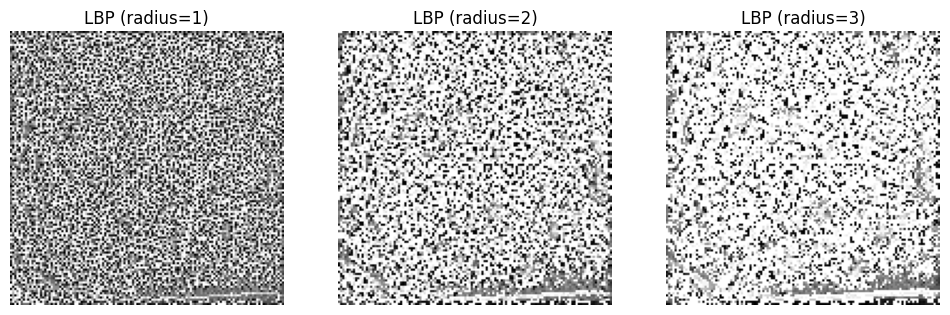

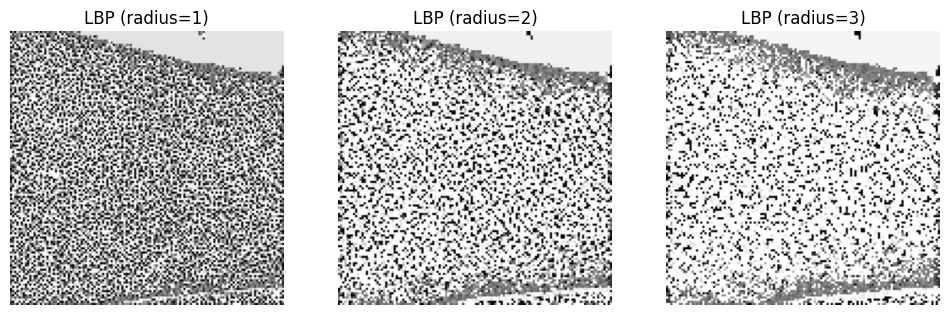

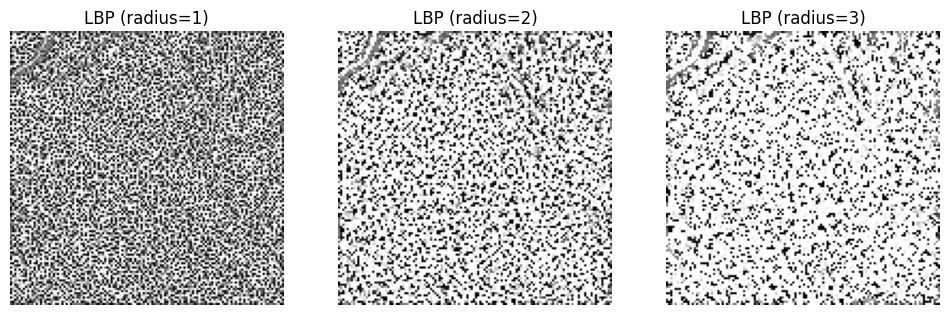

In [147]:
lbp_df, glcm_df = prepare_dataset(image_paths, labels)


=== Training CNN on LBP Features ===
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.6593 - val_accuracy: 0.0000e+00 - val_loss: 0.7367
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.6611 - val_accuracy: 0.0000e+00 - val_loss: 0.7505
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 1.0000 - loss: 0.6175 - val_accuracy: 0.0000e+00 - val_loss: 0.7649
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.6099 - val_accuracy: 0.0000e+00 - val_loss: 0.7790
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.6168 - val_accuracy: 0.0000e+00 - val_loss: 0.7938
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 1.0000 - loss: 0.6023 - val_accuracy: 0.0000e+00 - val_loss: 0.8084
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 1.0000 - loss: 0.5995 - val_accuracy: 0.0000e+00 - val_loss: 0.8234
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accur

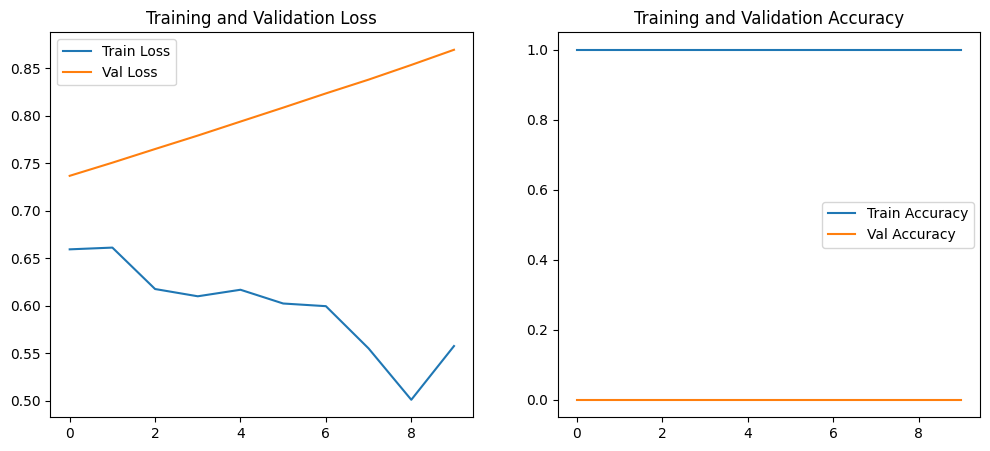

In [185]:
# Train CNN using LBP features
lbp_data = lbp_df.drop('label', axis=1).values
lbp_labels = lbp_df['label'].values

print("\n=== Training CNN on LBP Features ===")
train_dense(lbp_data, lbp_labels)


=== Training GLCM Classifier ===
GLCM Classifier Accuracy: 0.0000


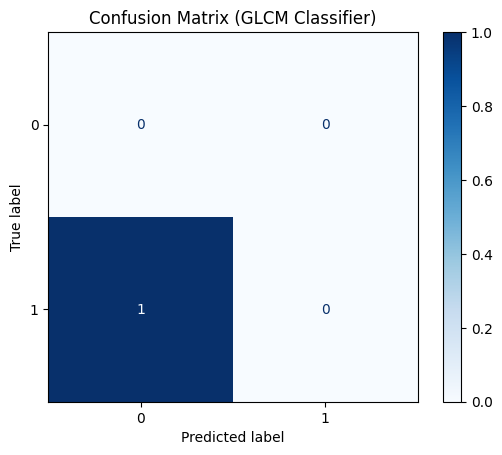

In [186]:
# Train GLCM classifier
print("\n=== Training GLCM Classifier ===")
train_glcm_classifier(glcm_df)